<a href="https://colab.research.google.com/github/furkanardadincer/CreditRiskPrediction/blob/main/ClassWeightFCNN_KrediRiskTahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Mount Google Drive
df = pd.read_csv('/content/drive/MyDrive/giveMeSomeCredit/archive/cs-training.csv')

In [4]:
# 2. Gereksiz sütunları at, eksikleri doldur
df.drop('Unnamed: 0', axis=1, inplace=True)
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(0, inplace=True)

<ipython-input-4-0f4048bb00a8>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
<ipython-input-4-0f4048bb00a8>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [5]:
# 3. X ve y ayır
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

In [6]:
# 4. Ölçekleme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# 5. Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
# 6. Class weight hesapla
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.5360493165371214), 1: np.float64(7.434944237918216)}


In [9]:
# 7. Modeli tanımla
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# 8. Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
# 9. Eğit
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.6728 - loss: 0.6233 - val_accuracy: 0.8515 - val_loss: 0.4655
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8033 - loss: 0.5349 - val_accuracy: 0.8217 - val_loss: 0.5029
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8052 - loss: 0.5316 - val_accuracy: 0.8459 - val_loss: 0.4836
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8099 - loss: 0.5212 - val_accuracy: 0.8402 - val_loss: 0.4882
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8096 - loss: 0.5201 - val_accuracy: 0.7741 - val_loss: 0.5302
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8005 - loss: 0.5213 - val_accuracy: 0.8379 - val_loss: 0.4650
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8137 - loss: 0.5089 - val_accuracy: 0.8230 - val_loss: 0.4656
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8109 - loss: 0

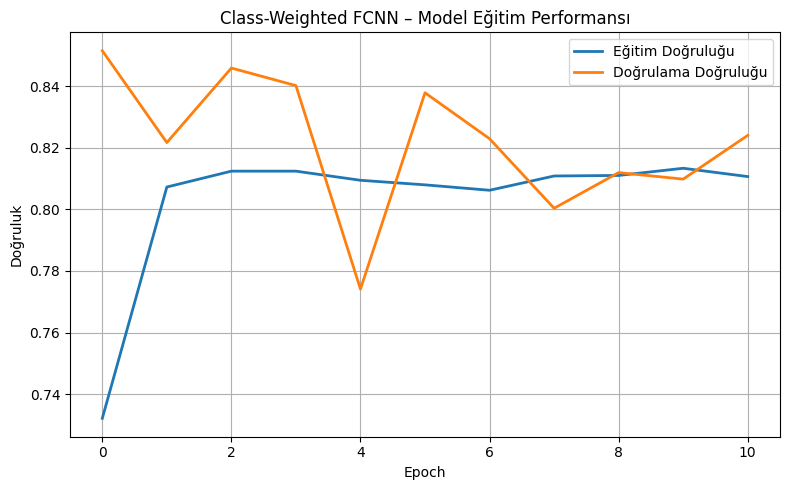

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', linewidth=2)
plt.title('Class-Weighted FCNN – Model Eğitim Performansı')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


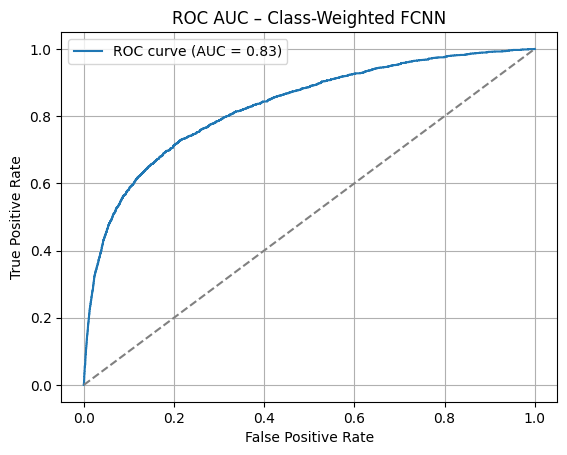

In [13]:
# 10. ROC eğrisi
y_proba = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC – Class-Weighted FCNN')
plt.legend()
plt.grid()
plt.show()


In [14]:
# 11. Performans raporu
y_pred = (y_proba > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     28044
           1       0.23      0.66      0.34      1956

    accuracy                           0.84     30000
   macro avg       0.60      0.75      0.62     30000
weighted avg       0.92      0.84      0.87     30000

